# Laboratoire numéro 1

Imports

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors

## Step 1

In [2]:
nodes = pd.read_csv('Documentation/nodes.csv', header=None, names=["Node","x_position","y_position"], index_col=0)
edges = pd.read_csv('Documentation/links.csv', header=None, names=[
    "Link ID", 
    "Length (m)",
    "Number of lanes", 
    "Starting node ID",
    "Ending node ID", 
    "Region"], index_col=0)
occupancy = pd.read_csv('Documentation/occupancy.csv', index_col = 0)
flow = pd.read_csv('Documentation/flow.csv', index_col = 0)

time_in_min = 120
time = time_in_min * 60
occupancy_at_t = occupancy.loc[time]
occupancy_at_t.name = f"Occupancy at time {time}"
color_at_t = occupancy_at_t/100
color_at_t.name = f"Colors in gray scale at time {time}"
color_at_t = color_at_t.astype(str)

edges_at_t = edges
edges_at_t["Occupancy"] = occupancy_at_t.values
edges_at_t["Color"] = color_at_t
edges_at_t = edges_at_t.replace(np.nan,0)

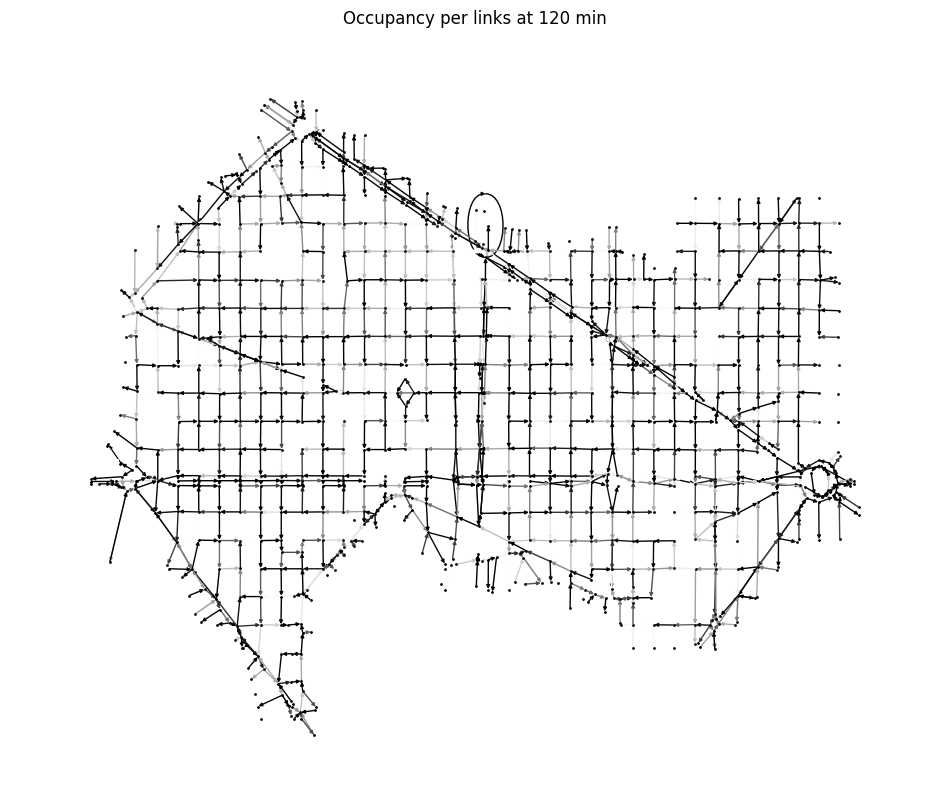

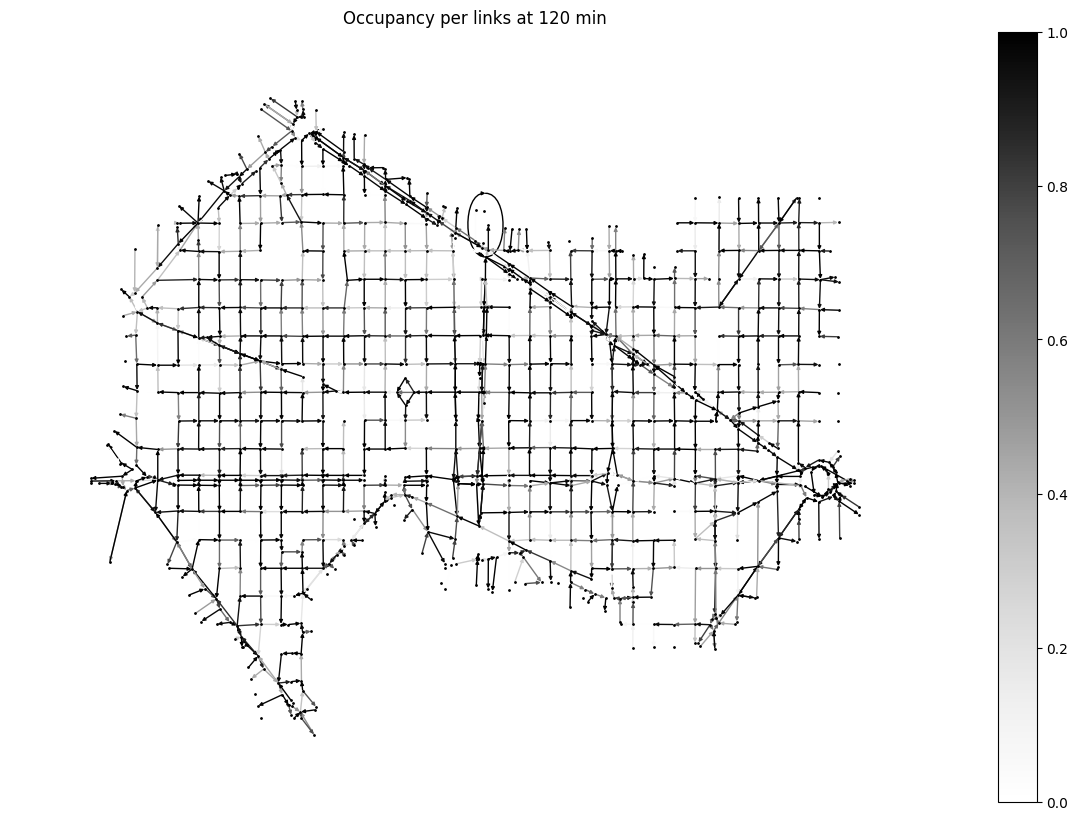

In [3]:
G = nx.from_pandas_edgelist(edges_at_t, create_using = nx.MultiDiGraph, source = "Starting node ID", target= "Ending node ID", edge_attr=["Length (m)", "Number of lanes", "Region","Occupancy","Color"])

plt.figure(figsize=(12,10))
plt.title(f"Occupancy per links at {time_in_min} min")
nx.draw(G, node_color = "0",arrowsize = 5, node_size = 1, pos=nodes.transpose(), edge_cmap = plt.cm.gray, edge_color = color_at_t)

# Your existing code for creating the graph

# Create a colormap based on "color_at_t"
cmap = plt.get_cmap('Greys')

# Add the colorbar to the same axes where you're plotting the graph
fig, ax = plt.subplots(figsize=(15, 10))
plt.title(f"Occupancy per links at {time_in_min} min")
nx.draw(G, node_color="0", arrowsize=5, node_size=1, pos=nodes.transpose(), edge_cmap=cmap, edge_color=color_at_t, ax=ax)

# Create the ScalarMappable
sm = plt.cm.ScalarMappable(cmap=cmap)
#sm.set_array([])  # Empty array

# Add the colorbar
cbar = plt.colorbar(sm, ax=ax)

# Show the plot
plt.show()

## Step 2

(80, 1570)
(80,)


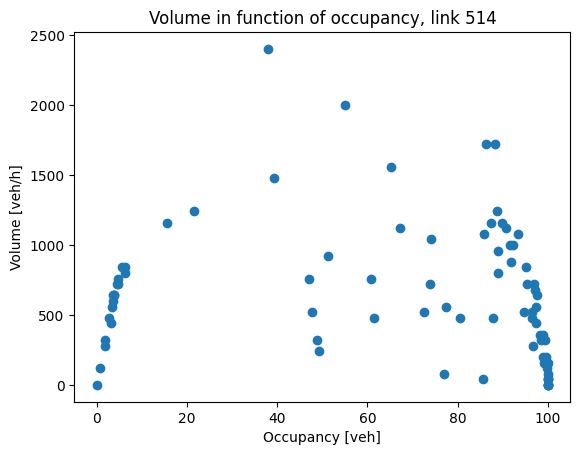

In [4]:
def vol_occ_graph_1link(number_link):

    flow_l = flow.loc[:, f'{number_link}']*3600/90 # In vehicles per hour
    occupancy_single_road = occupancy.loc[:, f'{number_link}'] # In vehicles

    print(flow.shape)
    print(occupancy_single_road.shape)

    plt.scatter(occupancy_single_road, flow_l)
    plt.xlabel("Occupancy [veh]")
    plt.ylabel("Volume [veh/h]")
    plt.title(f"Volume in function of occupancy, link {number_link}")
    plt.show()

    return None

vol_occ_graph_1link(514)

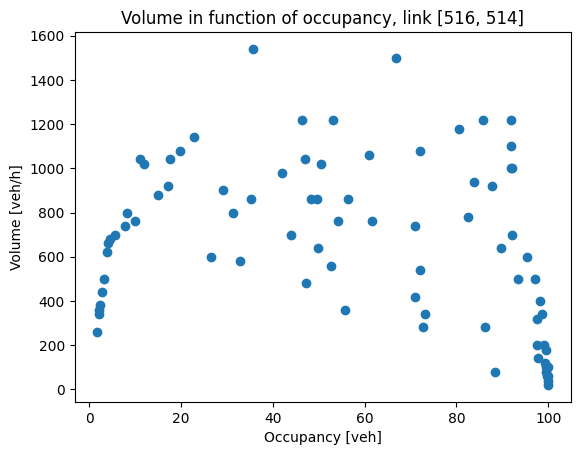

In [5]:
def vol_occ_graph_2links(number_link):

    flow_l= flow[[f'{number_link[0]}', f'{number_link[1]}']]
    flow_mean = flow_l.mean(axis=1)*3600/90

    occupancy_l = occupancy[[f'{number_link[0]}', f'{number_link[1]}']]
    occupancy_mean = occupancy_l.mean(axis=1)

    plt.scatter(occupancy_mean, flow_mean)   
    plt.xlabel("Occupancy [veh]")
    plt.ylabel("Volume [veh/h]")
    plt.title(f"Volume in function of occupancy, link {number_link}") 
    plt.show()

    return None

number_link = [516, 514]

vol_occ_graph_2links(number_link)

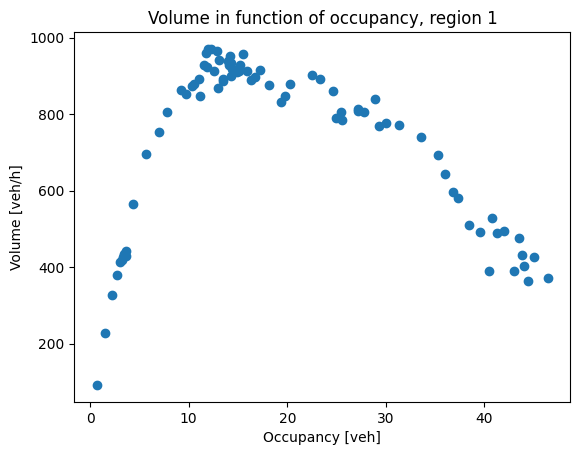

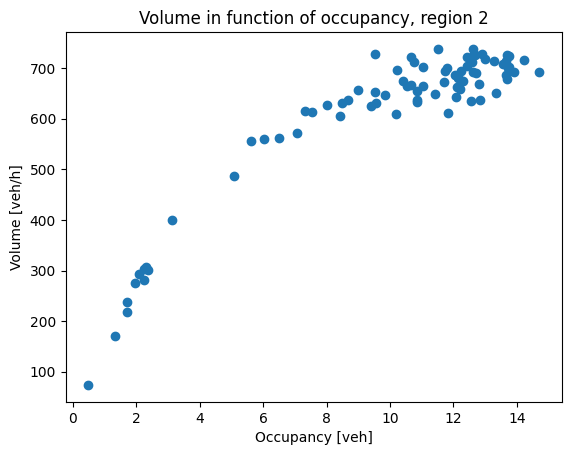

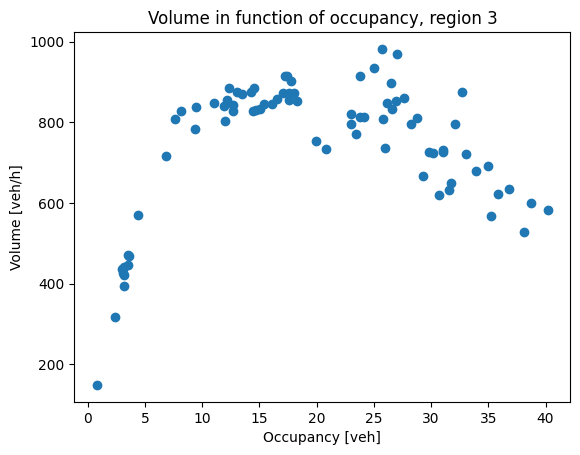

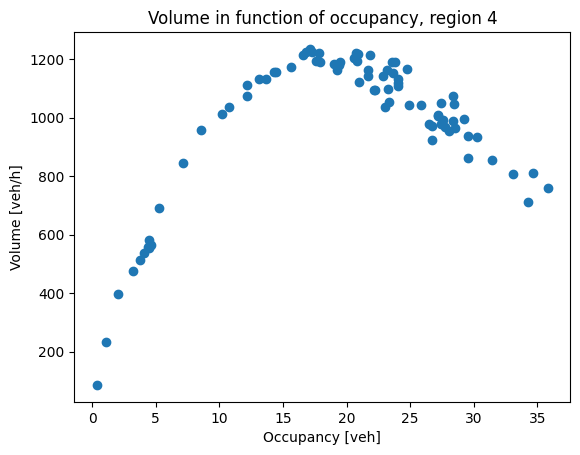

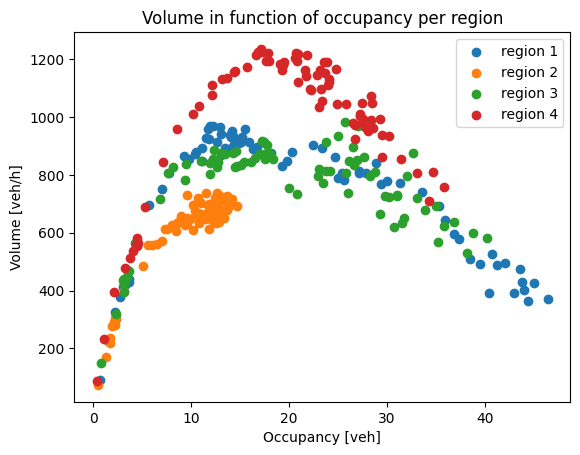

In [6]:
def vol_occ_graph_region(region):

    number_link = []

    for index in edges.index:
        if edges.loc[index]["Region"] == region:
            number_link.append(str(index))
        
    flow_l= flow[number_link]
    flow_mean = flow_l.mean(axis=1)*3600/90

    occupancy_l = occupancy[number_link]
    occupancy_mean = occupancy_l.mean(axis=1)

    plt.scatter(occupancy_mean, flow_mean)   
    plt.xlabel("Occupancy [veh]")
    plt.ylabel("Volume [veh/h]")
    plt.title(f"Volume in function of occupancy, region {region}")  
    plt.show()

    return occupancy_mean, flow_mean

# region = [1,2,3,4]

# for i in region:
#     occ_mean_i, flow_mean_i = vol_occ_graph_region(i)
#     plt.scatter(occ_mean_i, flow_mean_i, label=f'Region {region}')  

# plt.legend()
# plt.show()

occ1, flow1 = vol_occ_graph_region(1)
occ2, flow2 = vol_occ_graph_region(2)
occ3, flow3 = vol_occ_graph_region(3)
occ4, flow4 = vol_occ_graph_region(4)

plt.scatter(occ1, flow1, label=f'region 1') 
plt.scatter(occ2, flow2, label=f'region 2') 
plt.scatter(occ3, flow3, label=f'region 3') 
plt.scatter(occ4, flow4, label=f'region 4')   
plt.xlabel("Occupancy [veh]")
plt.ylabel("Volume [veh/h]")
plt.title(f"Volume in function of occupancy per region")  
plt.legend()
plt.show()

# Step 3

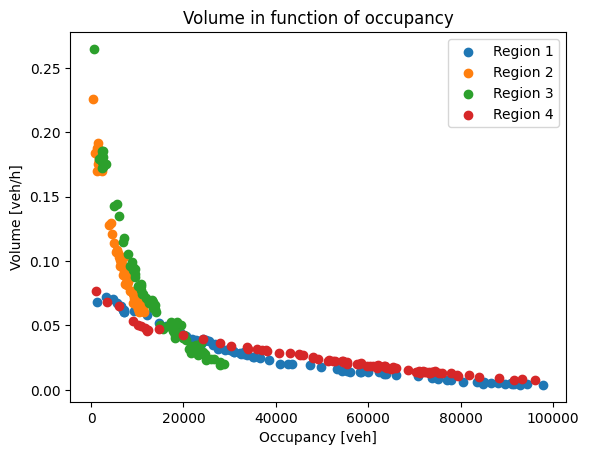

In [7]:
regions = [1,2,3,4]

for region in regions:

    number_link_int = []
    number_link_str = []

    L = 5/1000 # Average vehicle lenght [m]
    Ld = 2/1000 # Detector lenght [m]

    for index in edges.index:
        if edges.loc[index]["Region"] == region:
            number_link_int.append(int(index))
            number_link_str.append(str(index))

    number_lane = edges.loc[number_link_int, "Number of lanes"].to_numpy()
    length_lane = edges.loc[number_link_int, "Length (m)"].to_numpy()

    occupancy_region = occupancy[number_link_str].to_numpy()

    number_lane = np.tile(number_lane, (number_lane.shape[0], 1))

    density = (occupancy_region / 100) @ number_lane.T / (Ld + L)

    flow_region = flow[number_link_str].to_numpy() * 3600 / 90

    link_speed = flow_region @ density.T

    length_lane = np.tile(length_lane, (length_lane.shape[0], 1))

    mean_speed = np.mean(flow_region @ length_lane, axis=1) / np.mean(density @ length_lane, axis=1)

    average_density = np.mean(density, axis=1)

    plt.scatter(average_density, mean_speed, label=f'Region {region}')  


plt.xlabel("Occupancy [veh]")
plt.ylabel("Volume [veh/h]")
plt.title(f"Volume in function of occupancy")  
plt.legend()   
plt.show()

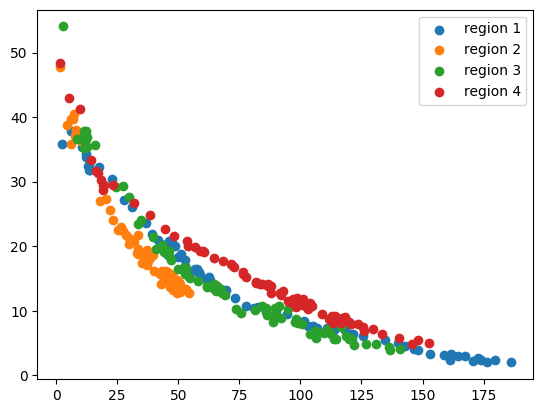

In [8]:
Region = [1,2,3,4] #Version de JC

for region in Region:
    number_link_int = []
    number_link_str = []

    L = 5/1000
    Ld = 2/1000

    for index in edges.index:
        if edges.loc[index]["Region"] == region:
            number_link_int.append(int(index))
            number_link_str.append(str(index))

    number_lane = edges.loc[number_link_int, "Number of lanes"].to_numpy()
    length_lane = edges.loc[number_link_int, "Length (m)"].to_numpy()

    occupancy_region = occupancy[number_link_str].to_numpy() #%
    number_lane = np.diag(number_lane)

    density = (occupancy_region/100) @ np.transpose(number_lane)/(Ld + L)

    flow_region = flow[number_link_str].to_numpy()*3600/90

    link_speed = flow_region@np.transpose(density)

    length_lane = np.tile(length_lane, (length_lane.shape[0], 1))

    mean_speed = np.sum(flow_region@length_lane, axis=1)/np.sum(density@length_lane, axis=1)

    average_density = np.mean(density,axis=1)

    plt.scatter(average_density, mean_speed, label=f'region {region}')   
   
plt.legend()    
plt.show()

# Step 4

In [11]:
def density_link(link):
    L = 5/1000
    Ld = 2/1000
    number_lane = edges.loc[link, "Number of lanes"]
    occupancy_link = occupancy[str(link)] #%
    density = occupancy_link / 100 * number_lane / (L + Ld)
    return density

def accumulation_link(link):
    length = edges.loc[link, "Length (m)"]
    density = density_link(link)
    accumulation = length * density
    return accumulation
    
def production_link(link):
    length = edges.loc[link, "Length (m)"]
    volume = flow.loc[:, f'{link}'] * 3600 / 90 # Same volume as in part 2
    production = volume * length
    return production

def accumulation_2links(links):
    accumulations = []

    for link in links:
        acc = accumulation_link(link)
        accumulations.append(acc.to_numpy())

def production_2links(links):
    productions = []

    for link in links:
        prod = production_link(link)
        productions.append(prod.to_numpy())
    
    return productions

def accumulation_region(region):
    accumulations = []
    links = []

    for index in edges.index:
        if edges.loc[index]["Region"] == region:
            links.append(int(index))

    for link in links:
        acc = accumulation_link(link)
        accumulations.append(acc.to_numpy())

    return accumulations  

def production_region(region):
    productions = []
    links = []

    for index in edges.index:
        if edges.loc[index]["Region"] == region:
            links.append(int(index))

    for link in links:
        prod = production_link(link)
        productions.append(prod.to_numpy())
        
    return productions 


4.1 - Single link

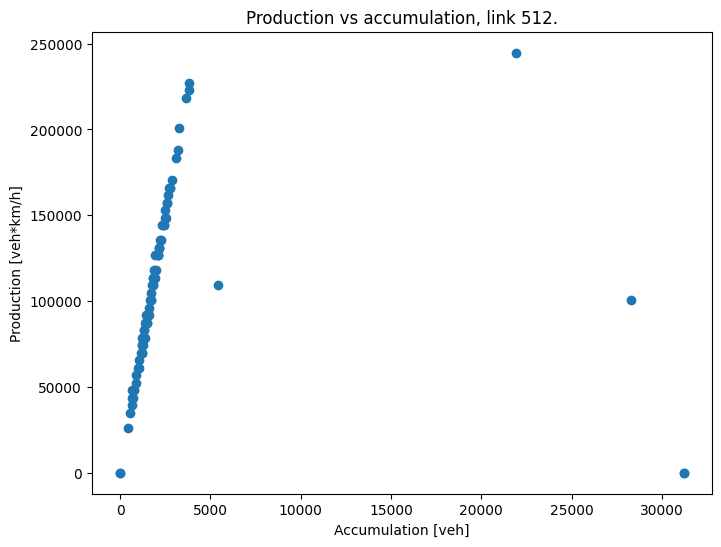

In [12]:
link = 512

plt.figure(figsize=(8,6))
plt.title(f'Production vs accumulation, link {link}.')
plt.scatter(accumulation_link(512), production_link(512))
plt.xlabel('Accumulation [veh]')
plt.ylabel('Production [veh*km/h]')
plt.show()

4.2 - Two links

ValueError: x and y must be the same size

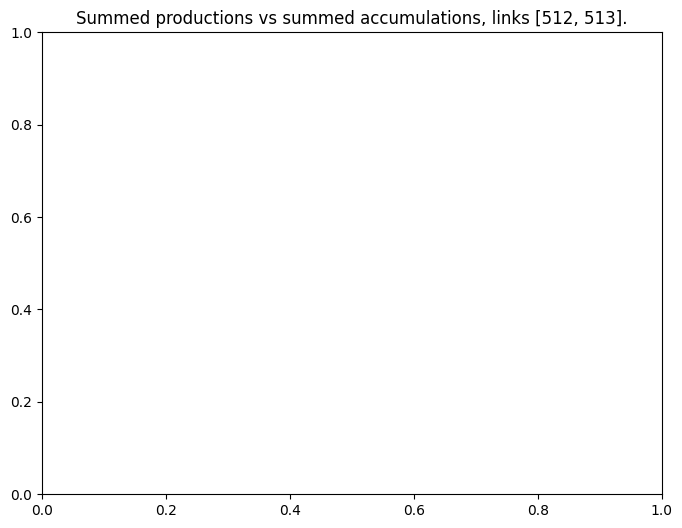

In [13]:
links = [512, 513]

accumulations = []
productions = []

summed_accumulations = []
summed_productions = []

accumulations = accumulation_2links(links)
productions = production_2links(links)

summed_accumulations = np.sum(accumulations, axis = 0)
summed_productions = np.sum(productions, axis = 0)

# plt.figure(figsize=(8,6))
# plt.title(f'Production vs accumulation, links {links}.')
# for i in range(len(links)):
#     plt.scatter(accumulations[i], productions[i], label = f'Link {links[i]}')
# plt.xlabel('Accumulation [veh]')
# plt.ylabel('Production [veh*km/h]')
# plt.legend()
# plt.show()

plt.figure(figsize=(8,6))
plt.title(f'Summed productions vs summed accumulations, links {links}.')
plt.scatter(summed_accumulations, summed_productions)
plt.xlabel('Accumulation [veh]')
plt.ylabel('Production [veh*km/h]')
plt.show()

4.3 - All regions

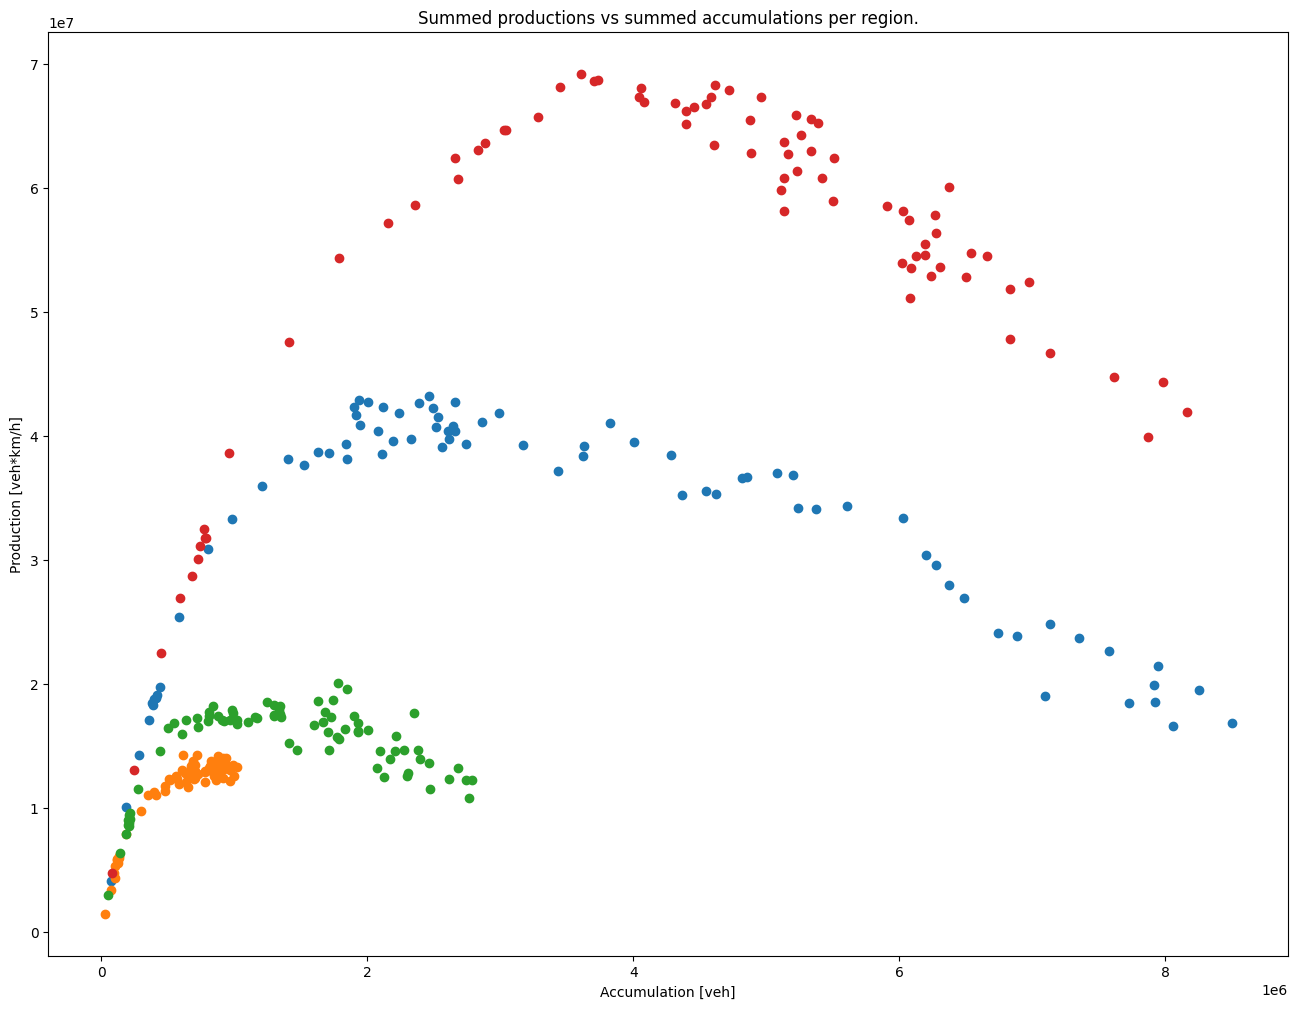

In [75]:
regions = [1,2,3,4]

plt.figure(figsize=(16,12))
plt.title(f'Summed productions vs summed accumulations per region.')

for region in regions:
    summed_accumulations = np.sum(accumulation_region(region), axis = 0)
    summed_productions = np.sum(production_region(region), axis = 0)
    plt.scatter(summed_accumulations, summed_productions, label = f"Region {region}")

plt.xlabel('Accumulation [veh]')
plt.ylabel('Production [veh*km/h]')
plt.show()

# Old versions

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import csv

def printgraph(x,y,xname,yname,unit1, unit2):
    plt.plot(x,y,'o')
    plt.plot(x,y,'b')

    plt.title(f'{yname} as a function of {xname}')
    plt.xlabel(f"{xname} ({unit1})")
    plt.ylabel(f"{yname} ({unit2})")

    plt.show()

    return None

graph_type = nx.Graph()

nodes = pd.read_csv('Documentation/nodes.csv', header=None)
nodes.columns = ["Node ID", "x_coordinate", "y_coordinate"]
nodescoordinates = nodes.iloc[:,1:]
nodesid = nodes.iloc[:,0]

links = pd.read_csv('Documentation/links.csv', header=None)
links.columns = ["Link ID", "Lenght", "Number of lanes", "Starting node ID", "Ending node ID", "Region"]

couple = pd.Series

#G = nx.from_pandas_edgelist(nodesid, source='x_coordinate', target='y_coordinate', create_using=graph_type)

G = nx.Graph()

G.add_nodes_from(nodes["Node ID"])
# G.add_edges_from(links[])

axes = plt.axes()

nx.draw(G, ax = axes)

# printgraph()

# print("test")


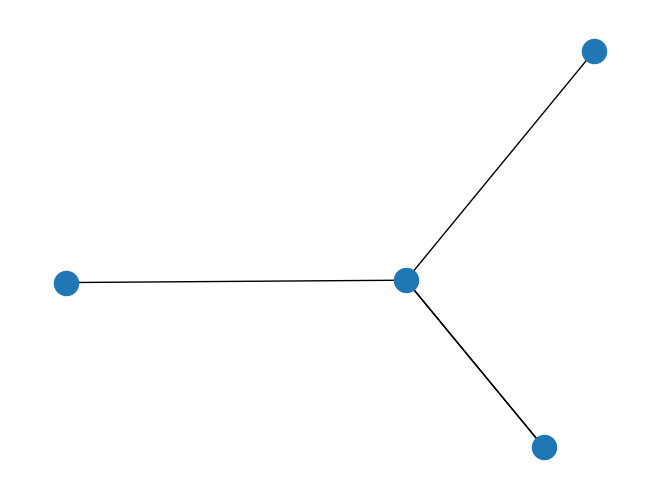

In [13]:
edges = pd.DataFrame(
    {
        "source": [0, 1, 2, 0],
        "target": [2, 2, 3, 2],
        "my_edge_key": ["A", "B", "C", "D"],
        "weight": [3, 4, 5, 6],
        "color": ["red", "blue", "blue", "blue"],
    }
)
G = nx.from_pandas_edgelist(
    edges,
    edge_key="my_edge_key",
    edge_attr=["weight", "color"],
    create_using=nx.MultiGraph(),
)
G[0][2]

nx.draw(G)
plt.show()